Описание проекта  

Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.  
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## 1. Подключитесь к базе. Загрузите таблицы sql

Импортируем библиотеки, подключаемся к базе, смотрим на наши таблицы и данные

In [1]:
!pip install shap

     |████████████████████████████████| 572 kB 2.2 MB/s eta 0:00:01


In [2]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 8.0 kB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor, cv, train
from sklearn.preprocessing import RobustScaler, StandardScaler
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import recall_score, precision_score
import time
import shap
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import make_column_transformer, make_column_selector
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string) 

## 2. Проведите первичное исследование таблиц

In [6]:
def get_sample_data(table_name, limit):
    query = f"SELECT * FROM {table_name} LIMIT {limit}"
    sample_data = pd.read_sql_query(query, con=engine)
    return display(sample_data.head())

In [7]:
sample_collisions = get_sample_data("collisions", 10)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [8]:
sample_case_ids = get_sample_data("case_ids", 10)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [9]:
sample_vehicles = get_sample_data("vehicles", 10)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [10]:
sample_parties = get_sample_data("parties", 10)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


Все на месте!  
Таблицы имеют набор данных  
Количество столбцов соответсвует условию задачи  
общий ключ имеется `case_id`

## 3. Проведите статистический анализ факторов ДТП

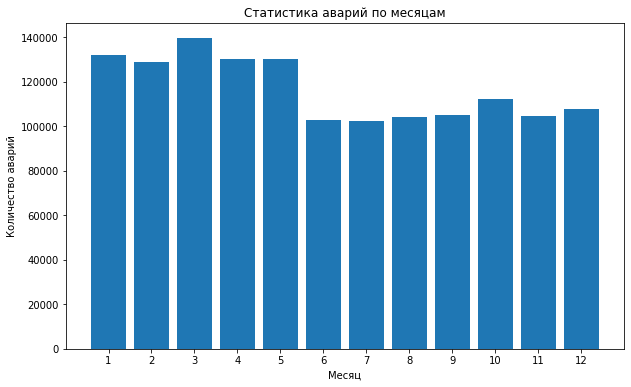

In [11]:
query = '''
SELECT 
    EXTRACT(MONTH FROM collision_date) AS month,
    COUNT(*) AS collision_count
FROM
    collisions
GROUP BY
    month
ORDER BY
    collision_count DESC;
'''
df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.bar(df['month'], df['collision_count'])
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Статистика аварий по месяцам')
plt.xticks(df['month'])
plt.show()

Больше всего аварий происходит в марте, возможно потому что некоторые люди переоделись на летнюю резину, а по ночам еще бывает холодно

### Статистические задачи

Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП   
Зависимость типа повреждений от кузова  
Зависимость наличия в машине громкой связи от времени суток  
Зависимость региона от трезвости  
Зависимость типа коробки передач от трезвости
Зависимость региона от возраста машины

Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП  


Мы выбираем уникальные значения столбца "road_surface" и "collision_damage" из таблицы "collisions".  
Мы также вычисляем количество повреждений ("collision_damage") для каждой комбинации "road_surface" и "collision_damage". Для этого используется оконная функция COUNT вместе с оператором PARTITION BY для группировки по "road_surface" и упорядочивания по "collision_damage".  
Мы ограничиваем результат только теми записями, где "case_id" присутствует в подзапросе, который выбирает уникальные "case_id" из таблицы "parties", где "party_type" равно 'car'.  
Результат сортируется по "road_surface" и "col_count" (количество повреждений).  

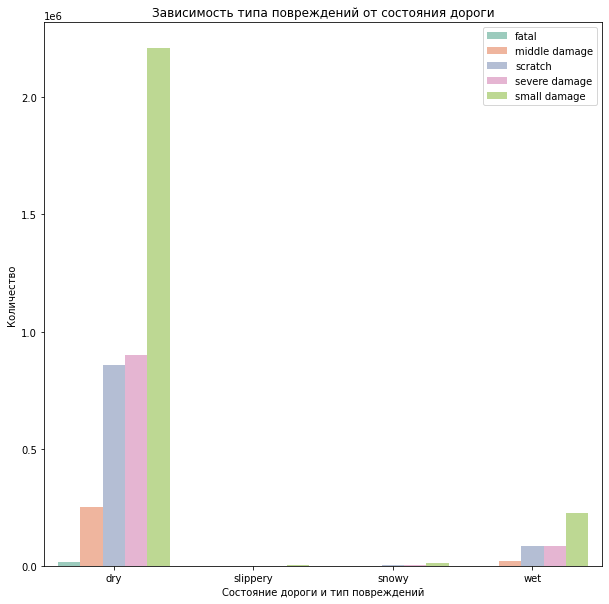

In [12]:
query = '''
SELECT DISTINCT c.road_surface, c.collision_damage, 
       COUNT(c.collision_damage) OVER (PARTITION BY c.road_surface ORDER BY c.collision_damage) AS col_count
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.party_type = 'car'
ORDER BY c.road_surface, col_count
'''
df_weather = pd.read_sql(query, con=engine)

# Установка размера
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot(data=df_weather,
            x='road_surface',
            y='col_count',
            hue='collision_damage',
            palette="Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Состояние дороги и тип повреждений",
       ylabel="Количество")
plt.title("Зависимость типа повреждений от состояния дороги")
plt.show()

как не было бы странно, но большинство аварий происходит на сухой дороге, в большинстве случаем это аварии с маленьким уроном

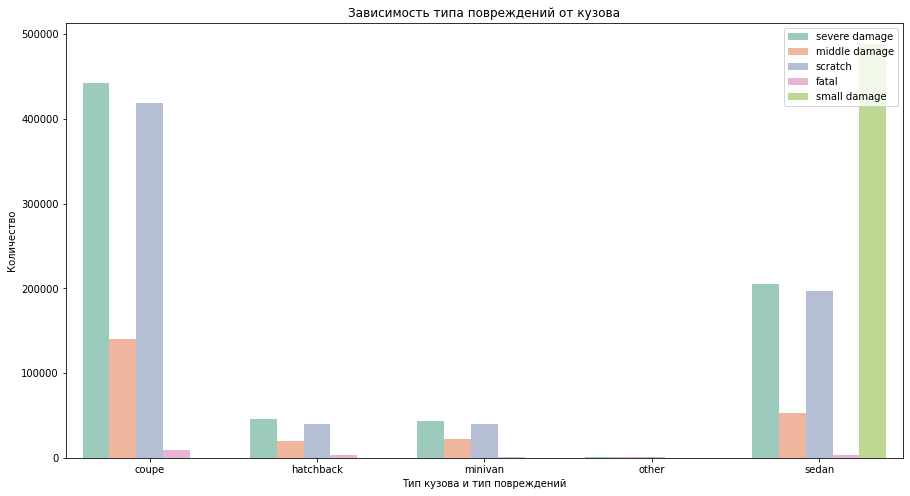

In [13]:
query = '''
select *,
col_count/SUM(col_count) over (partition by vehicle_type) as prcnt
from (
        select distinct collision_damage, vehicle_type,
        count(collision_damage) over(partition by vehicle_type order by collision_damage) as col_count
from(
        select case_id , collision_damage 
        from collisions) c 
        join(
        select case_id, vehicle_type
        from vehicles) v  on c.case_id = v.case_id) t
'''

df_body = pd.read_sql(query, engine)

f, ax = plt.subplots(figsize=(15, 8))

#
sns.barplot(data =df_body, 
            x='vehicle_type',
            y = 'col_count',
            hue  = 'collision_damage',
            palette = "Set2",
            alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Тип кузова и тип повреждений",
       ylabel="Количество")
plt.title("Зависимость типа повреждений от кузова")
plt.show()

На этом графике можно увидеть что в ДТП купе обычно получают серьезный ущерб или царапины, а седаны в основном мелкий ремонт

## 4. Создайте модель для оценки водительского риска

### 1. Собираем общий df  с которым будем работать

In [14]:
query = '''
select  
        at_fault,
        vehicle_type,
        vehicle_age, 
        insurance_premium,
        party_sobriety,
        party_drug_physical,
        cellphone_in_use,
        intersection,
        weather_1,
        location_type,
        road_surface,
        road_condition_1,
        lighting,
        CAST(collision_date AS DATE) AS collision_date,
        collision_time
  FROM parties AS p
       INNER JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
       INNER JOIN collisions AS c ON p.case_id = c.case_id
 WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''
df = pd.read_sql_query(query, con=engine)
df.head()

,at_fault,vehicle_type,vehicle_age,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,collision_date,collision_time
0,1,sedan,2.0,34.0,had not been drinking,None,0.0,0.0,cloudy,None,dry,normal,daylight,2012-01-02,13:22:00
1,1,sedan,5.0,38.0,"had been drinking, under influence",None,0.0,0.0,clear,intersection,dry,other,dark with no street lights,2012-05-01,00:01:00
2,0,sedan,NaN,NaN,impairment unknown,G,0.0,0.0,clear,highway,dry,normal,daylight,2012-04-19,12:44:00
3,1,sedan,8.0,43.0,had not been drinking,None,0.0,0.0,clear,None,dry,normal,dark with street lights,2012-04-19,22:04:00
4,1,sedan,6.0,38.0,"had been drinking, under influence",None,0.0,0.0,clear,None,dry,normal,dark with no street lights,2012-04-21,00:50:00


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   at_fault             56248 non-null  int64  
 1   vehicle_type         56248 non-null  object 
 2   vehicle_age          54554 non-null  float64
 3   insurance_premium    55701 non-null  float64
 4   party_sobriety       55376 non-null  object 
 5   party_drug_physical  2857 non-null   object 
 6   cellphone_in_use     51777 non-null  float64
 7   intersection         56073 non-null  float64
 8   weather_1            56080 non-null  object 
 9   location_type        25932 non-null  object 
 10  road_surface         55900 non-null  object 
 11  road_condition_1     55999 non-null  object 
 12  lighting             56094 non-null  object 
 13  collision_date       56248 non-null  object 
 14  collision_time       56160 non-null  object 
dtypes: float64(4), int64(1), object(10)


Оставляю по моему мнению критерии, которые могут влиять на попадание в ДТП  

vehicle_type - тип кузова, вряд ли человек на минивене будет гонять в центральном рряду на кутузовском проспекте  
vehicle_age - возраст машины  
insurance_premium - страховая выплата, если будет КАСКО, то верояно водитель будет вести себя более беспечно поскольку ему целиком компенсируют ущерб  
party_sobriety - трезвость, думаю тут все ясно=)  
party_drug_physical - Состояние участника: физическое или с учётом принятых лекарств  
cellphone_in_use - громкая связь в авто    
intersection - Является ли место происшествие перекрёстком  
weather_1 - погода  
location_type - грунтовка или шоссе имеет огромное значение  
road_surface - сухая или в снегу, тоже огромное значение  
road_condition_1 - ямки наше все  
lighting - освещенность участка
collision_date - дата (разобьем на месяц день и день недели)
collision_time -время(разобьем на время суток)

### 2. Перейдем к обработке данных

проверяем дубликаты, при наличии удаляем

In [16]:
df.duplicated().sum()

38

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.duplicated().sum()

0

Посмотрим значения в столбцах, сколько их и обработаем пропуска, во многих столбцах есть занчение `other`, все неопределенное будем пихать туда, для числовых, подгоним к медиане, поскольку не очень много пропусков в столбцах, дату разделим на месяц , день, день недели. Время на время суток (утро, день, вечер , ночь)

In [19]:
df['vehicle_type'].value_counts()

sedan    37168
coupe    19038
other        4
Name: vehicle_type, dtype: int64

In [20]:
df = df.drop(df[df['vehicle_type'] == 'other'].index)
df['vehicle_type'].value_counts()

sedan    37168
coupe    19038
Name: vehicle_type, dtype: int64

In [21]:
df['vehicle_age'].value_counts()

3.0      11001
4.0       7152
2.0       6042
5.0       5562
6.0       3935
7.0       3834
8.0       3508
0.0       3087
9.0       2766
1.0       2545
10.0      1941
11.0      1379
12.0       879
13.0       551
14.0       282
15.0        37
16.0         6
17.0         3
161.0        2
19.0         1
Name: vehicle_age, dtype: int64

In [22]:
# Удаление строки с значением "161"
df = df.drop(df[df['vehicle_age'] == 161].index)
# Заменим пропуска на медиану
median_age = df['vehicle_age'].median()
df['vehicle_age'].fillna(median_age, inplace=True)
# Преобразование формата столбца 'vehicle_age' в тип int
df['vehicle_age'] = df['vehicle_age'].astype(int)
df['vehicle_age'].value_counts()

3     11001
4      8845
2      6042
5      5562
6      3935
7      3834
8      3508
0      3087
9      2766
1      2545
10     1941
11     1379
12      879
13      551
14      282
15       37
16        6
17        3
19        1
Name: vehicle_age, dtype: int64

In [23]:
median_insurance_premium = df['insurance_premium'].median()
df['insurance_premium'].fillna(median_insurance_premium, inplace=True)

In [24]:
df['party_sobriety'].value_counts()

had not been drinking                     48537
had been drinking, under influence         4473
impairment unknown                         1238
had been drinking, not under influence      575
had been drinking, impairment unknown       261
not applicable                              250
Name: party_sobriety, dtype: int64

In [25]:
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')

In [26]:
df['party_drug_physical'].value_counts()

G                        1238
under drug influence      857
sleepy/fatigued           390
not applicable            250
impairment - physical     122
Name: party_drug_physical, dtype: int64

In [27]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')

party_drug_physical_map = {
    'G': 'impairment unknown'
}

df['party_drug_physical'] = df['party_drug_physical'].apply(lambda x: party_drug_physical_map[x] if x in party_drug_physical_map else x)


In [28]:
df['cellphone_in_use'].value_counts()   

0.0    50684
1.0     1054
Name: cellphone_in_use, dtype: int64

In [29]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)

In [30]:
df['intersection'].value_counts()  

0.0    43615
1.0    12414
Name: intersection, dtype: int64

In [31]:
df['intersection'] = df['intersection'].fillna(0)
df['intersection'].value_counts()  

0.0    43790
1.0    12414
Name: intersection, dtype: int64

In [32]:
df['weather_1'].value_counts()

clear      45059
cloudy      8418
raining     2178
fog          181
snowing      157
other         34
wind          11
Name: weather_1, dtype: int64

In [33]:
df['weather_1'] = df['weather_1'].fillna('other')
df['weather_1'].value_counts()

clear      45059
cloudy      8418
raining     2178
other        200
fog          181
snowing      157
wind          11
Name: weather_1, dtype: int64

In [34]:
df['location_type'].value_counts()

highway         21303
ramp             3264
intersection     1342
Name: location_type, dtype: int64

In [35]:
df['location_type'] = df['location_type'].fillna('other')
df['location_type'].value_counts()

other           30295
highway         21303
ramp             3264
intersection     1342
Name: location_type, dtype: int64

In [36]:
df['road_surface'].value_counts()

dry         50205
wet          5252
snowy         357
slippery       43
Name: road_surface, dtype: int64

In [37]:
df['road_surface'] = df['road_surface'].fillna('other')
df['road_surface'].value_counts()

dry         50205
wet          5252
snowy         357
other         347
slippery       43
Name: road_surface, dtype: int64

In [38]:
df['road_condition_1'].value_counts()

normal            54025
construction       1002
obstruction         248
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: road_condition_1, dtype: int64

In [39]:
df['road_condition_1'] = df['road_condition_1'].fillna('other')
df['road_condition_1'].value_counts()

normal            54025
construction       1002
other               475
obstruction         248
holes               222
loose material      128
reduced width        72
flooded              32
Name: road_condition_1, dtype: int64

In [40]:
df['lighting'].value_counts()

daylight                                   38032
dark with street lights                    11011
dark with no street lights                  5105
dusk or dawn                                1768
dark with street lights not functioning      135
Name: lighting, dtype: int64

In [41]:
df['lighting'] = df['lighting'].fillna('other')
df['lighting'].value_counts()

daylight                                   38032
dark with street lights                    11011
dark with no street lights                  5105
dusk or dawn                                1768
other                                        153
dark with street lights not functioning      135
Name: lighting, dtype: int64

In [42]:
df['collision_time'].replace('', np.nan, inplace=True)
df.dropna(subset=['collision_time'], inplace=True)
df['collision_time'].isnull().sum()

0

In [43]:
df['collision_time'] = df['collision_time'].astype(str)

# Преобразование строки в формат datetime
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S', errors='coerce')

# Извлечение часов из столбца 'collision_time'
df['hour'] = df['collision_time'].dt.hour

# Замена пропущенных значений в столбце 'hour' на медиану
median_hour = df['hour'].median()
df['hour'].fillna(median_hour, inplace=True)

# Создание категориального столбца 'time_category'
time_bins = [0, 6, 12, 18, 23]
time_labels = ['ночь', 'утро', 'день', 'вечер']
df['time_category'] = pd.cut(df['hour'], bins=time_bins, labels=time_labels, right=False)

In [44]:
df.dropna(subset=['time_category'], inplace=True)

In [45]:
df['time_category'].unique()

['день', 'ночь', 'вечер', 'утро']
Categories (4, object): ['ночь' < 'утро' < 'день' < 'вечер']

In [46]:
df = df.drop(['collision_time', 'hour'], axis=1)

In [47]:
df['collision_date'] = pd.to_datetime(df['collision_date'])

df['month'] = df['collision_date'].dt.month
df['day'] = df['collision_date'].dt.day
df['weekday'] = df['collision_date'].dt.weekday
df = df.drop(['collision_date'], axis=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54744 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   at_fault             54744 non-null  int64   
 1   vehicle_type         54744 non-null  object  
 2   vehicle_age          54744 non-null  int64   
 3   insurance_premium    54744 non-null  float64 
 4   party_sobriety       54744 non-null  object  
 5   party_drug_physical  54744 non-null  object  
 6   cellphone_in_use     54744 non-null  float64 
 7   intersection         54744 non-null  float64 
 8   weather_1            54744 non-null  object  
 9   location_type        54744 non-null  object  
 10  road_surface         54744 non-null  object  
 11  road_condition_1     54744 non-null  object  
 12  lighting             54744 non-null  object  
 13  time_category        54744 non-null  category
 14  month                54744 non-null  int64   
 15  day                

In [49]:
df.head()

,at_fault,vehicle_type,vehicle_age,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,time_category,month,day,weekday
0,1,sedan,2,34.0,had not been drinking,impairment unknown,0.0,0.0,cloudy,other,dry,normal,daylight,день,1,2,0
1,1,sedan,5,38.0,"had been drinking, under influence",impairment unknown,0.0,0.0,clear,intersection,dry,other,dark with no street lights,ночь,5,1,1
2,0,sedan,4,34.0,impairment unknown,impairment unknown,0.0,0.0,clear,highway,dry,normal,daylight,день,4,19,3
3,1,sedan,8,43.0,had not been drinking,impairment unknown,0.0,0.0,clear,other,dry,normal,dark with street lights,вечер,4,19,3
4,1,sedan,6,38.0,"had been drinking, under influence",impairment unknown,0.0,0.0,clear,other,dry,normal,dark with no street lights,ночь,4,21,5


От пропусков избавились, ДФ готов к оубчению

Созддадим новый df для тех признаков которые могут влять на ДТП

### 3. Избивались от пропускоов , далее подготовим данные к обучению

Посмотрим на баланс классов


In [50]:
df['at_fault'].value_counts(normalize=True) * 100


1    50.096814
0    49.903186
Name: at_fault, dtype: float64

Есть небольшой дисбаланс, думаю он не критичен

Разбиваем данные на выборки, кодируем с помощью таргетэнкода, затем масштабируем количественные

In [51]:
df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=12345), [int(.6*len(df)), int(.8*len(df))])

In [52]:
categorical_features = ['vehicle_type', 'party_sobriety', 'party_drug_physical',
                        'weather_1', 'location_type', 'road_surface',
                        'road_condition_1', 'lighting', 'time_category']
num_features = ['vehicle_age', 'insurance_premium', 'cellphone_in_use',
                'intersection', 'month', 'day', 'weekday']

In [53]:
X_train = df_train.drop(['at_fault'], axis=1)
y_train = df_train['at_fault']
X_valid = df_valid.drop(['at_fault'], axis=1)
y_valid = df_valid['at_fault']
X_test = df_test.drop(['at_fault'], axis=1)
y_test = df_test['at_fault']

In [54]:
encoder = ce.TargetEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_valid_encoded = encoder.transform(X_valid)
X_test_encoded = encoder.transform(X_test)

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[num_features])
X_valid_scaled = scaler.transform(X_valid_encoded[num_features])
X_test_scaled = scaler.transform(X_test_encoded[num_features])

выведем размер новых dfов


In [56]:
print("Train shape:", X_train_scaled.shape)
print("Valid shape:", X_valid_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (32846, 7)
Valid shape: (10949, 7)
Test shape: (10949, 7)


In [57]:
y_train.value_counts(normalize=True) * 100

1    50.267917
0    49.732083
Name: at_fault, dtype: float64

In [58]:
y_test.value_counts(normalize=True) * 100

0    50.278564
1    49.721436
Name: at_fault, dtype: float64

## 5. Найдите лучшую модель

Определеим параметры для gridsearch

In [59]:
decision_tree_params = {'max_depth': [3, 5, 7]}

random_forest_params = {'n_estimators': [10, 20, 30],
                        'max_depth': [3, 5, 7]}

catboost_params = {'depth': [3, 5, 7],
                   'learning_rate': [0.01, 0.1, 1]}


Создадим 3 классификатора

В каечстве метрики будем использовать f1 учитывая, что важно обнаружить и предсказать как можно больше случаев ДТП с повреждением транспортного средства, рекомендуется использовать метрику, которая уделяет внимание как точности, так и полноте предсказаний.

F1-метрика является хорошим выбором в данном контексте, так как она учитывает и точность, и полноту модели. При оценке риска ДТП, высокая точность будет означать, что большинство предсказанных случаев ДТП являются действительными, а высокая полнота будет означать, что модель обнаруживает большую долю реальных случаев ДТП.

Выберем f1 потому что она включает в себя точность и полноту, так же в отличии от accuarcy f1 учитывает дисбаланс классов

In [60]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
catboost = CatBoostClassifier(verbose=False)

In [61]:
decision_tree_grid = GridSearchCV(decision_tree, decision_tree_params, scoring='f1', cv=5)

random_forest_grid = GridSearchCV(random_forest, random_forest_params,
                                  scoring='f1', cv=5)

catboost_grid = GridSearchCV(catboost, catboost_params,
                             scoring='f1', cv=5)

Обучим модели

In [62]:
%%time

decision_tree_grid.fit(X_train_scaled, y_train)

CPU times: user 445 ms, sys: 7.23 ms, total: 452 ms
Wall time: 453 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7]}, scoring='f1')

In [63]:
%%time

random_forest_grid.fit(X_train_scaled, y_train)

CPU times: user 7.97 s, sys: 7.82 ms, total: 7.98 s
Wall time: 7.99 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7], 'n_estimators': [10, 20, 30]},
             scoring='f1')

In [ ]:
%%time

catboost_grid.fit(X_train_scaled, y_train)

In [ ]:
print("Лучшие параметры LogisticRegression:", decision_tree_grid.best_params_)
print("Лучшее значение f1 LogisticRegression:", decision_tree_grid.best_score_)
print("Лучшие параметры RandomForestClassifier:", random_forest_grid.best_params_)
print("Лучшее значение f1 RandomForestClassifier:", random_forest_grid.best_score_)
print("Лучшие параметры CatBoostClassifier:", catboost_grid.best_params_)
print("Лучшее значение f1 CatBoostClassifier:", catboost_grid.best_score_)

Лучший результат f1 показал CatBoost

Лучшие параметры CatBoostClassifier: {'depth': 5, 'learning_rate': 1}  
Лучшее значение f1 CatBoostClassifier: 0.57

будем использовать эту модель для тестовых данных

In [ ]:
%%time

best_catboost = CatBoostClassifier(max_depth=5, learning_rate=1, verbose=False)
best_catboost.fit(X_train_scaled, y_train)


y_pred = best_catboost.predict(X_test_scaled)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)



f1 = f1_score(y_test, y_pred)

print("Значение F1 для catboost на тестовых данных:", f1)
print("Значение precision для catboost на тестовых данных:", precision)
print("Значение recall для catboost на тестовых данных:", recall)

## 6. Проверьте лучшую модель в работе

Посмотрим на матрицу ошибок

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion matrix')
plt.show()

Верно классифицированных положительных результатов (True Positives, TP) было 2940. Это говорит о том, что модель правильно предсказала положительные исходы в 2940 случаях.

Верно классифицированных отрицательных результатов (True Negatives, TN) было 3044. Это означает, что модель правильно предсказала отрицательные исходы в 3044 случаях.

Ложно положительных результатов (False Positives, FP) было 2532. Это означает, что модель ошибочно предсказала положительные исходы в 2532 случаях.

Ложно отрицательных результатов (False Negatives, FN) было 2433. Это говорит о том, что модель ошибочно предсказала отрицательные исходы в 2433 случаях.

In [ ]:
y_prob = best_catboost.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Построение графика точности
plt.plot(thresholds, precision[:-1])
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('График точности')
plt.show()

In [ ]:
y_prob_rec = best_catboost.predict_proba(X_test_scaled)[:, 1]

# Вычисление точности и полноты для различных пороговых значений
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rec)

# Построение графика полноты
plt.plot(thresholds, recall[:-1])
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('ГРафик полноты')
plt.show()

Посмотрим на зависимость числа ДТП от разных факторов

In [ ]:
feature_importances = best_catboost.feature_importances_
plt.bar(X_test.columns[:len(feature_importances)], feature_importances)
plt.xticks(rotation=90)
plt.title('Признаки влияющие на аварийность')
plt.show()

сильнее всего влияет возраст машины

In [ ]:
##v.vehicle_age, p.at_fault
query = '''
SELECT v.vehicle_age, COUNT(*) AS accident_count
FROM collisions c
JOIN vehicles v ON c.case_id = v.case_id
WHERE v.vehicle_age IS NOT NULL
    and v.vehicle_age < 21
GROUP BY v.vehicle_age
ORDER BY v.vehicle_age
'''

df = pd.read_sql(query, con=engine)

#Установка размера
plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='vehicle_age', y='accident_count', color='skyblue')
plt.xlabel("Возраст автомобиля")
plt.ylabel("Количество аварий")
plt.title("Зависимость количества аварий от возраста автомобиля")
plt.show()

Кажется если вашей машине 3 года, стоит водить аккуратнее

## 7. Сделайте общий вывод по модели

1. Лучший результат f1 показал CatBoost
Лучшие параметры CatBoostClassifier: {'depth': 5, 'learning_rate': 1}   
Лучшее значение f1 CatBoostClassifier: 0.52  


2. Итог по матрице ошибок  

Верно классифицированных положительных результатов (True Positives, TP) было 2940. Это говорит о том, что модель правильно предсказала положительные исходы в 2940 случаях.

Верно классифицированных отрицательных результатов (True Negatives, TN) было 3044. Это означает, что модель правильно предсказала отрицательные исходы в 3044 случаях.

Ложно положительных результатов (False Positives, FP) было 2532. Это означает, что модель ошибочно предсказала положительные исходы в 2532 случаях.

Ложно отрицательных результатов (False Negatives, FN) было 2433. Это говорит о том, что модель ошибочно предсказала отрицательные исходы в 2433 случаях.

Самым важным фактором ДТП являтся возраст авто.  
нужно просто своевременно обновлять парк

Насколько возможно создание адекватной системы оценки риска при выдаче авто?  
Для этого нужен очень большой объем данных, но думаю это вполне реально для ЯД у них есть тариф фикс, возможно в него уже вшита эта функция, если нет, то ее можно вшить именно туда, поскольку можно добавить в модель параметры которые можно знать только при построении опредленного маршрута, фикс, на сколько я понимаю умеет анализировать его и на основе построенного маршрута и оценки данных выдает цену, в этом случае можно учитывать качество дорог, тип дорог, статистику по авариям на маршруте и тд  
так что чисто в теории для тарифа ФИКС можно довести эту модель до совершенства используя кучу разных факторов, которые нельзя будет использовать в минутном тарифе.


Какие факторы ещё необходимо собирать, чтобы улучшить модель?  
Думаю самым важным является усталость водителя, я встречал такие опции в машинах, которые отлеживают взгяд водителя и его сконцентрированность на дороге, опять же надо оценить выгодно ли это будет реальзовать.  
Так же проблемой являются фековые аккаунты, уверен, что в этом случае ДТП переваливают за 50%, добавить селфи перед поездкой, думаю это реальзовать проще всего, во многих каршерингах есть аная фича